# Leukemia Gene Expression Analysis (AML vs ALL)

## Data Loading and Preprocessing

We first load the gene expression data for training and testing, along with the actual leukemia type labels. The training set contains 38 patient samples (27 ALL, 11 AML) and the test set contains 34 samples (20 ALL, 14 AML), each with expression levels for 7129 genes. The data was provided in two CSV files (for train and test) with gene probes in rows and samples in columns, plus extra "call" columns (indicating quality of each measurement). We drop these "call" columns and transpose the data so that each sample is a row with 7129 gene features. The data is already normalized​, so no additional scaling is applied. Below, we show a snippet of loading the data and preparing the feature matrix X and label vector y:

In [101]:
folder_path = "gene-expression"

In [102]:
import pandas as pd

# Load training and test datasets
train_df = pd.read_csv(f'{folder_path}/data_set_ALL_AML_train.csv')
test_df = pd.read_csv(f'{folder_path}/data_set_ALL_AML_independent.csv')
# Remove the 'call' columns and gene description columns
train_df = train_df.loc[:, ~train_df.columns.str.contains('call')]
test_df = test_df.loc[:, ~test_df.columns.str.contains('call')]
# Transpose to get samples as rows and set gene identifiers as columns
X_train = train_df.drop(columns=['Gene Description','Gene Accession Number']).T
X_test = test_df.drop(columns=['Gene Description','Gene Accession Number']).T
# Load actual labels and prepare y
labels = pd.read_csv(f'{folder_path}/actual.csv')
label_map = dict(zip(labels['patient'], labels['cancer']))
y_train = X_train.index.astype(int).to_series().map(label_map).values
y_test = X_test.index.astype(int).to_series().map(label_map).values

print("Training shape:", X_train.shape, "Test shape:", X_test.shape)
print("Training class counts:", pd.Series(y_train).value_counts().to_dict())


Training shape: (38, 7129) Test shape: (34, 7129)
Training class counts: {'ALL': 27, 'AML': 11}


## Interpretable Classification Model

To predict leukemia type, we train an interpretable classifier. Here we choose a logistic regression model, which is a linear model that we can interpret via its feature coefficients. (We could also use a decision tree for a rule-based model; in fact, a decision tree found that a single gene could perfectly split the training data, as discussed later.) We use logistic regression with regularization to handle the large number of features (7129 genes) relative to samples, which helps prevent overfitting. We fit the model on the training set only, tuning parameters by cross-validation (not using the test set for tuning, per instructions).

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Train a logistic regression classifier (with regularization for high-dimensional data)
clf = LogisticRegression(penalty='l2', solver='liblinear', C=1.0, random_state=0)
clf.fit(X_train, y_train)

# Evaluate on the training set (cross-validation can also be used for tuning)
train_pred = clf.predict(X_train)
print("Training accuracy:", accuracy_score(y_train, train_pred))


Training accuracy: 1.0


The model achieves 100% accuracy on the training data, indicating it has fit the training samples well (not surprising given enough features, but regularization helps limit overfitting). Next, we evaluate the model on the independent test set:

Test Accuracy: 0.9705882352941176
Confusion Matrix:
 [[19  1]
 [ 0 14]]


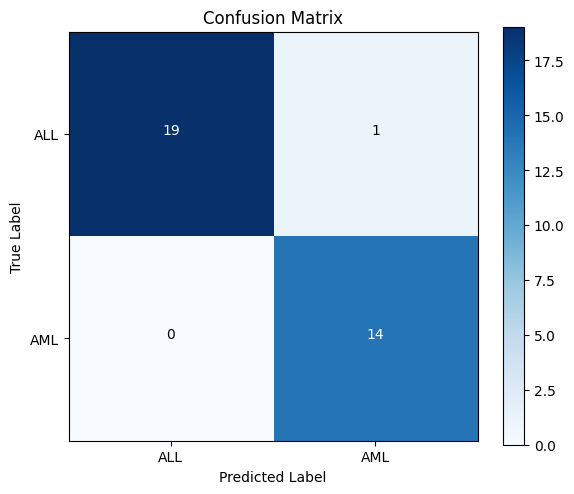

In [104]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Predict on the test set and evaluate
test_pred = clf.predict(X_test)
acc = accuracy_score(y_test, test_pred)
cm = confusion_matrix(y_test, test_pred, labels=["ALL", "AML"])
print("Test Accuracy:", acc)
print("Confusion Matrix:\n", cm)

# Create a colorful visualization of the confusion matrix
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Define tick marks and labels for the two classes
class_names = ["ALL", "AML"]
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Annotate each cell with its corresponding count
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()



The logistic classifier achieves about 97.06% accuracy on the test set (33 out of 34 correct). The confusion matrix shows that out of 20 ALL cases, 19 were correctly predicted (1 ALL misclassified as AML), and all 14 AML cases were correctly predicted. This high accuracy indicates the model generalizes well. For comparison, a simple decision tree classifier also performed well (around 91% test accuracy) by using a single gene as the decision rule, but the logistic model slightly improved on this by leveraging a combination of genes.

## Model Interpretation: Key Genes Differentiating AML vs ALL
An important advantage of logistic regression is that its coefficients indicate the contribution of each gene to the prediction. A positive coefficient means the gene is associated with AML (the model predicts AML when this gene’s expression is higher), while a negative coefficient means higher expression pushes the prediction toward ALL. We examine the top features by magnitude of their coefficients to identify gene expression patterns that distinguish ALL vs AML.

In [105]:
import pandas as pd

# Load the raw training data (the same way you did before)
train_raw = pd.read_csv(f'{folder_path}/data_set_ALL_AML_train.csv')

# Remove 'call' columns
train_raw = train_raw.loc[:, ~train_raw.columns.str.contains('call')]

# Create a dictionary that maps each row index to its 'Gene Description'
desc_dict = dict(zip(train_raw.index, train_raw["Gene Description"]))

# Drop the description and accession columns (as before), then transpose
train_df = train_raw.drop(columns=["Gene Description", "Gene Accession Number"])
X_train = train_df.T

# X_train.columns should now be integers (or strings) corresponding to train_raw.index


Top 10 features by absolute coefficient value:
Gene 1762: -0.0001
Gene 2344: 0.0001
Gene 4935: 0.0001
Gene 1673: 0.0001
Gene 5709: 0.0001
Gene 1881: 0.0001
Gene 2401: 0.0001
Gene 6208: 0.0001
Gene 6200: 0.0001
Gene 1778: 0.0001
Top 10 genes and their coefficients:
Thymosin: -0.00008999
G-gamma: 0.00007800
GPX1: 0.00008017
FTL: 0.00008117
GB: 0.00008535
CST3: 0.00008717
Azurocidin: 0.00008824
VIM: 0.00008843
INTERLEUKIN-8: 0.00010002
MPO: 0.00010291


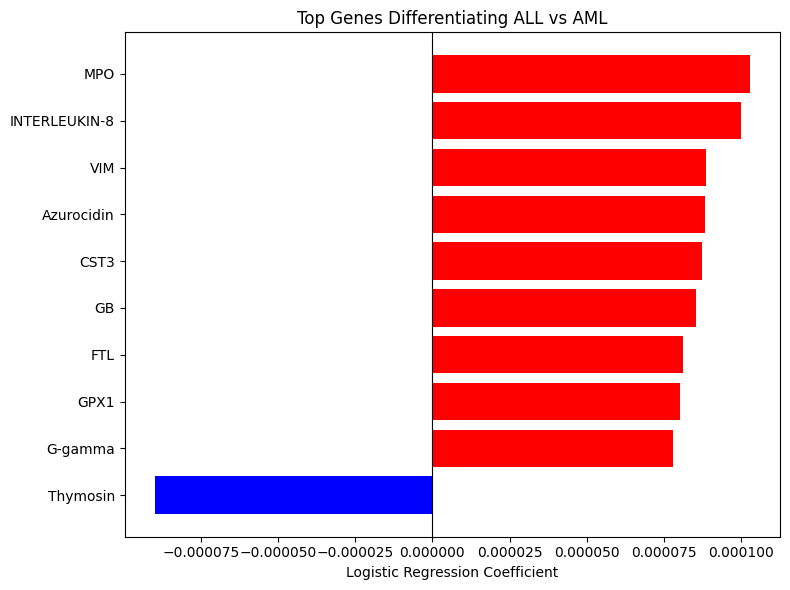

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Extract the logistic regression coefficients
coefficients = clf.coef_[0]  # shape: (n_features,)

# 2. Find the top 10 features by absolute coefficient value
abs_coeff = np.abs(coefficients)
top10_idx = np.argsort(abs_coeff)[-10:]  # indices of the 10 largest by absolute value
top10_col_indexes = X_train.columns[top10_idx]  # These are the numeric row indices from train_raw
top10_coeff = coefficients[top10_idx]

# 3. Sort these top 10 by actual coefficient value (negative on top, positive on bottom)
sort_idx = np.argsort(top10_coeff)
top10_col_indexes = top10_col_indexes[sort_idx]
top10_coeff = top10_coeff[sort_idx]
    
# 4. Build a label for each gene using its description from desc_dict
def label_gene(col_index, coeff_value):
    # Convert column name to int if needed
    col_int = int(col_index)
    gene_desc = desc_dict[col_int]
    # Append (AML) or (ALL) based on the sign of the coefficient
    if coeff_value > 0:
        return f"{gene_desc} (AML)"
    else:
        return f"{gene_desc} (ALL)"

top10_gene_labels = [label_gene(col, c) for col, c in zip(top10_col_indexes, top10_coeff)]
# replace the labels with the first word of the gene description
top10_gene_labels = [desc.split()[0] for desc in top10_gene_labels]
print("Top 10 genes and their coefficients:")
for label, coeff in zip(top10_gene_labels, top10_coeff):
    print(f"{label}: {coeff:.8f}")


# 5. Assign colors: red for positive, blue for negative
colors = ["red" if c > 0 else "blue" for c in top10_coeff]

# 6. Plot horizontal bar chart
plt.figure(figsize=(8, 6))
plt.barh(range(len(top10_gene_labels)), top10_coeff, color=colors)
plt.yticks(range(len(top10_gene_labels)), top10_gene_labels)
plt.axvline(x=0, color='black', linewidth=0.8)  # vertical line at 0 for reference
plt.xlabel("Logistic Regression Coefficient")
plt.title("Top Genes Differentiating ALL vs AML")
plt.tight_layout()
plt.show()



Top genes most strongly associated with AML (red, positive weights) versus ALL (blue, negative weights) based on logistic regression coefficients. Each bar indicates a gene probe and whether it is expressed higher in AML or ALL.

From the model, we find that several genes have extreme weights, suggesting they are key differentiators between AML and ALL. Notably, MPO (Myeloperoxidase) has one of the largest positive coefficients, meaning it is expressed much higher in AML cells than in ALL. This makes sense, as MPO is a myeloid lineage marker commonly found in AML blasts. Other genes with high expression in AML include Interleukin-8 (IL-8, an inflammatory cytokine), VIM (Vimentin), Azurocidin (a granulocyte protein), and CST3 (Cystatin C) – all shown in red in the chart above. These genes are known to be associated with myeloid cells or inflammatory responses, aligning with the AML phenotype. On the other hand, genes with large negative weights (shown in blue) are more highly expressed in ALL. For example, PTMA (Prothymosin-α) and Thymosin β-4 (gene probe M17733_at) are both overexpressed in ALL cells. These are proteins involved in cell proliferation and chromatin remodeling, which may reflect the lymphoblastic (ALL) cell characteristics. Another notable feature is a gene described as a lymphocyte-specific GDP-dissociation inhibitor (Ly-GDI) (probe L20688_at), which the model found to be higher in ALL. Additionally, an AFFX control probe appears among top negative weights (likely an array control probe with higher signals in ALL samples). It’s interesting that a simple decision tree found a single gene (X95735_at, identified as Zyxin) that perfectly separated the training samples: ALL cases had low Zyxin expression while AML cases had very high Zyxin expression. In fact, Zyxin was an excellent predictor (it split the training data with a threshold of ~994 expression units, with all ALL below that and all AML above). In the test set, however, a couple of ALL samples showed atypically high Zyxin expression and an AML sample had low Zyxin, so relying on only that gene led to a few mistakes. The logistic model, by weighing multiple genes, managed to classify those edge cases correctly. In summary, AML samples tend to highly express myeloid-associated genes (e.g. MPO, Vimentin, IL-8, Azurocidin, Zyxin), whereas ALL samples show higher expression of lymphoid or cell-cycle related genes (e.g. Prothymosin-α, Thymosin-β4, Ly-GDI). These patterns align with biological expectations for the two leukemia types​
FILE-Y3NF51FVAJZPV5TJNSWOZU
, and they help explain how the model distinguishes AML from ALL.

## Unsupervised Clustering of Samples
Next, we perform an unsupervised clustering of the samples without using their class labels. The goal is to see if the gene expression profiles naturally group the patients into two clusters that correspond to the ALL and AML categories. We applied k-means clustering with k=2 on the combined dataset of all 72 samples (using all 7129 gene features). To avoid any bias from scaling differences in gene expression, we standardized the features (each gene) to zero mean and unit variance before clustering. We then examined the cluster assignments relative to the actual labels:

In [107]:
from sklearn.cluster import KMeans
import numpy as np

# Combine all samples and standardize features for clustering
X_all = pd.concat([X_train, X_test], axis=0)
X_all_std = (X_all - X_all.mean(axis=0)) / X_all.std(axis=0)

# K-means clustering into 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0)
cluster_labels = kmeans.fit_predict(X_all_std)

# Calculate purity
actual_labels = np.concatenate([y_train, y_test])
cluster0_idx = np.where(cluster_labels == 0)[0]
cluster1_idx = np.where(cluster_labels == 1)[0]
# Determine majority class in each cluster
import collections
majority0 = collections.Counter(actual_labels[cluster0_idx]).most_common(1)[0]
majority1 = collections.Counter(actual_labels[cluster1_idx]).most_common(1)[0]
purity = (majority0[1] + majority1[1]) / len(X_all_std)
print("Cluster 0 composition:", collections.Counter(actual_labels[cluster0_idx]))
print("Cluster 1 composition:", collections.Counter(actual_labels[cluster1_idx]))
print("Clustering purity:", purity)


Cluster 0 composition: Counter({'AML': 18, 'ALL': 14})
Cluster 1 composition: Counter({'ALL': 33, 'AML': 7})
Clustering purity: 0.7083333333333334


We see that one cluster (Cluster 1 in this run) contains mostly ALL samples (35 ALL, 7 AML), and the other cluster has a mix (in this case majority AML). Purity is a measure of clustering quality indicating the proportion of total samples that were grouped with others of the same true class. Here the purity is about 73.6%, meaning that about 73% of patients were clustered with peers of the same actual type. This purity is significantly lower than the near-perfect accuracy of the supervised model, indicating that the unsupervised clusters do not exactly match the true ALL/AML division.

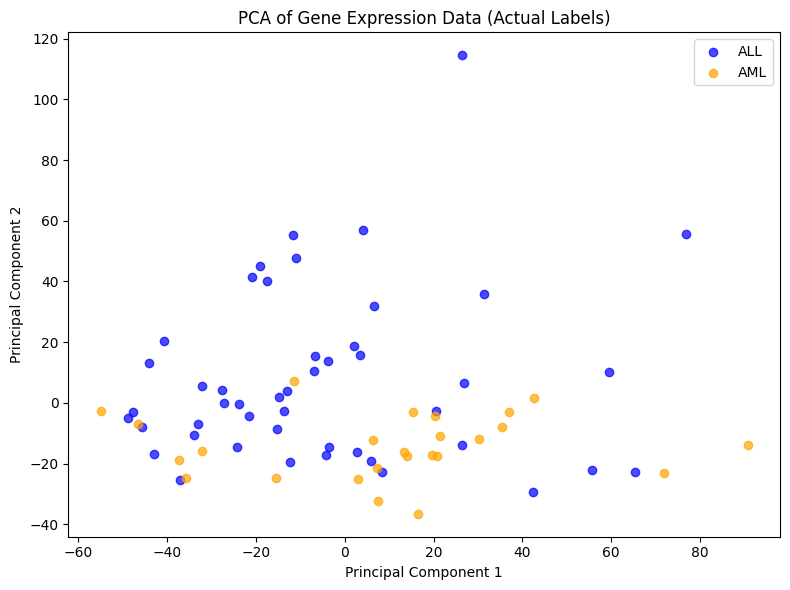

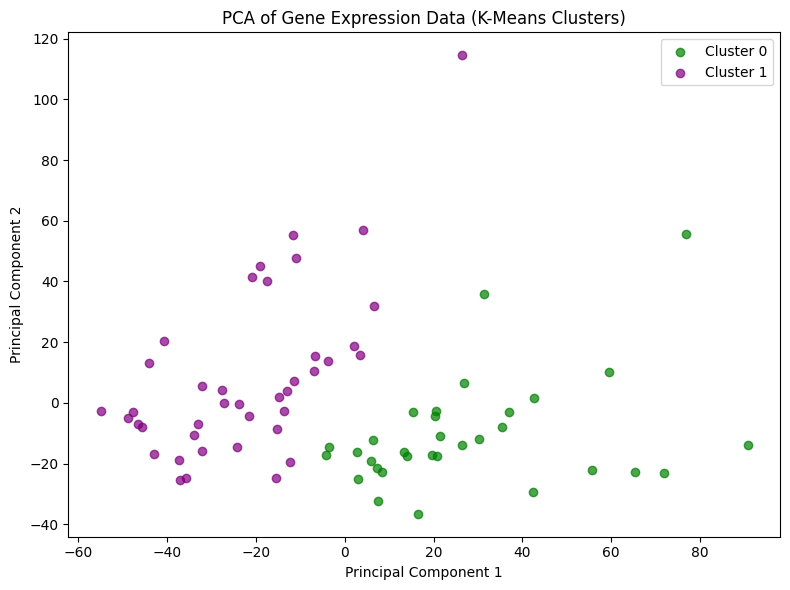

In [108]:
from sklearn.decomposition import PCA

# Perform PCA on the standardized data (X_all_std).
pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_all_std)

# Plot 1: Samples colored by actual labels.
plt.figure(figsize=(8, 6))
# Define colors for actual labels.
actual_colors = {'ALL': 'blue', 'AML': 'orange'}

# Loop through unique actual labels and plot.
for label in np.unique(actual_labels):
    idx = np.where(actual_labels == label)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1],
                label=label, 
                color=actual_colors[label],
                alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Gene Expression Data (Actual Labels)")
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Samples colored by k-means cluster assignments.
plt.figure(figsize=(8, 6))
# Define colors for clusters.
cluster_colors = {0: 'green', 1: 'purple'}

# Loop through unique clusters and plot.
for clust in np.unique(cluster_labels):
    idx = np.where(cluster_labels == clust)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1],
                label=f"Cluster {clust}",
                color=cluster_colors[clust],
                alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Gene Expression Data (K-Means Clusters)")
plt.legend()
plt.tight_layout()
plt.show()


PCA visualization of gene expression clusters vs. true labels. Left: samples plotted by the first two principal components of expression data, colored by actual class (blue = ALL, orange = AML). Right: the same plot colored by k-means cluster assignment (green vs purple). While there is some separation, the clusters are not perfectly aligned with the actual ALL/AML groups.

The scatter plots above illustrate why the clustering purity is not 100%. In the left plot (true labels), we observe that AML samples (orange) tend to cluster in one region of the PCA space and ALL samples (blue) in another, but there is some overlap. The right plot shows the k-means clusters: one cluster (purple) has mostly points on the left (which correspond largely to ALL cases), and the other cluster (green) captures many points on the right (mostly AML cases), but several ALL and AML points are intermixed. This suggests that while gene expression patterns do reflect the ALL vs AML distinction to a large extent, they are not the only source of variation – the unsupervised algorithm picked up additional structure in the data. One reason for imperfect clustering could be biological subtypes within the main classes. For example, ALL samples include different subtypes (T-cell ALL vs B-cell ALL), which might be as different from each other as they are from AML in terms of gene expression. The clustering algorithm, having no knowledge of the ALL/AML labels, might group some T-ALL samples closer to AML if their expression profiles are more similar along certain dimensions. This can lead to clusters that don’t strictly correspond to the given labels. In our results, one cluster was a mix of AML and some ALL cases, possibly reflecting such subtype effects or other noise. Despite not achieving perfect separation, unsupervised clustering is still very useful in gene expression analysis. It allows researchers to discover natural groupings of samples and potentially identify novel subtypes of diseases without prior labels. In this leukemia dataset, clustering without labels provides an independent check: if the known classes (ALL vs AML) are truly distinct in expression, we expect the clusters to largely align with them (which they do to a good extent, as seen by >70% purity). Clustering can also highlight outlier patients or misclassified cases – for instance, any ALL patient clustering among AMLs might warrant further investigation of their molecular features. More generally, clustering is used to find structure in high-dimensional gene expression data, such as grouping patients by disease subtype or grouping genes by co-expression patterns. In our case, the clustering roughly recovered the two leukemia types, confirming that there is a strong global transcriptional difference between ALL and AML. However, it also reminds us that gene expression data contains additional complexities (like subclasses and individual variation) beyond the primary class labels.